In [1]:
!pip install gdown

In [2]:
!gdown https://drive.google.com/uc?id=1TQv6oGf3uySrXGkB4iT__4wgycVadH8F
!gdown https://drive.google.com/uc?id=12-zJnHZaRNlHweeBOk0t2yHbkyvFRsf1

Downloading...
From: https://drive.google.com/uc?id=1TQv6oGf3uySrXGkB4iT__4wgycVadH8F
To: /content/train.csv
3.96MB [00:00, 62.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=12-zJnHZaRNlHweeBOk0t2yHbkyvFRsf1
To: /content/test.csv
100% 1.09M/1.09M [00:00<00:00, 71.8MB/s]


In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
#some libraries cause this future warnings when the newer versions will be released. To prevent showing them, this code is used.

Original Amazon Musical Instruments dataset contains around 230K reviews and ratings. However, training the model with this amount takes a lot of time. Therefore, we previously prepare the data as highly balanced and smaller size. The reason for that **handling imbalanced data is advanced topic, if you are interestedn in this, [you can follow this paper.](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=5128907)** The script includes data preparation steps will be shared with participants after the workshop.

In [22]:
import pandas as pd
df_train = pd.read_csv(r"train.csv",index_col=[0])
# Report the number of sentences.
print('Number of training sentences: {:,}\n'.format(df_train.shape[0]))
print()
print(df_train["label"].value_counts())
df_test = pd.read_csv(r"test.csv",index_col=[0])
# Report the number of sentences.
print()
print('Number of test sentences: {:,}\n'.format(df_test.shape[0]))
print()
print(df_test["label"].value_counts())

Number of training sentences: 10,500


2    3500
1    3500
0    3500
Name: label, dtype: int64

Number of test sentences: 3,000


1    1000
2    1000
0    1000
Name: label, dtype: int64


**Classes:**



0.   Negative
1.   Neutral
2.   Positive


In [23]:
df_train.head()

,review,label
0,I'm giving two stars simply because the capo d...,0
1,"Yes, it is possible to tell the difference bet...",0
2,Far too slippery for my fingers when I shreddi...,0
3,"I tried to ignore the other reviews, but I had...",0
4,I bought a set of 3 regular light gauge (.10) ...,0


In [24]:
df_test.head()

,review,label
0,This is one of the worst reverb pedals I have ...,0
1,I really like this at first. The ability to o...,0
2,This is an update to my original review becaus...,0
3,"It's OK. But if you try to raise the height, t...",0
4,"Loved the reviews, just wish it would have wor...",0


## TEXT PREPROCESSING

In [25]:
 df_train.review[100]

'I ordered two of these cables in April.  Today, on September 30, both are not operational.  PVC for connectors is a dumb idea.  Both cables have issues with the straight connector, if I move and hold the connector in an offset position, I can get a signal from the amp.  Other than that, no connection at all.  These cables were a total waste of money.  The 30 day return policy is BS.  I should be entitled to a refund.  Amazon should take responsibility because I bought the cable because touted these "best seller,".  Bestseller or not, these cables are cheap pieces of garbage.'

In [26]:
import numpy as np 
import nltk
import string as s
import re
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
lemmatizer=nltk.stem.WordNetLemmatizer()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from wordcloud import WordCloud

from sklearn.feature_extraction.text  import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics  import f1_score,accuracy_score
from sklearn.metrics import  confusion_matrix,classification_report

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Lemmatization is the process of converting a word to its base form. The difference between stemming and lemmatization is, lemmatization considers the context and converts the word to its meaningful base form, whereas stemming just removes the last few characters, often leading to incorrect meanings and spelling errors.

In [27]:
def preprocess(text,remove_stop_punc=False):
  text=text.lower()
  
  text=text.replace("\n"," ")
  #removing URL
  text = re.sub(r'https?:\/\/.*[\r\n]*', '', text)
  text = re.sub(r'http?:\/\/.*[\r\n]*', '', text)

  #Replace &amp, &lt, &gt with &,<,> respectively
  text=text.replace(r'&amp;?',r'and')
  text=text.replace(r'&lt;',r'<')
  text=text.replace(r'&gt;',r'>')

  #remove hashtags
  text=re.sub(r"#[A-Za-z0-9]+","",text)   
  #remove \
  text=re.sub(r"\\ "," ",text)
 
  #remove punctuations and stop words
  stop_words=stopwords.words('english')
  tokens=nltk.word_tokenize(text)
  if remove_stop_punc:
    tokens_new=[i for i in tokens if not i in stop_words and i.isalpha()] #isalpha() method returns True if all the characters are alphabet letters
  else:
    tokens_new=tokens
  #tokens_new=[lemmatizer.lemmatize(i) for i in tokens_new]
  #remove excess whitespace
  text= ' '.join(tokens_new)
  return text

df_train["review"]=df_train["review"].apply(preprocess,remove_stop_punc=False)
df_test["review"]=df_test["review"].apply(preprocess,remove_stop_punc=False)

#Remove reviews which have no word in them
df_train["Text_length"] = [len(text.split(' ')) for text in df_train.review]
df_train = df_train[df_train["Text_length"]>1]

#Remove reviews which have no word in them
df_test["Text_length"] = [len(text.split(' ')) for text in df_test.review]
df_test = df_test[df_test["Text_length"]>1]


In [28]:
df_train.review[100]

"i ordered two of these cables in april . today , on september 30 , both are not operational . pvc for connectors is a dumb idea . both cables have issues with the straight connector , if i move and hold the connector in an offset position , i can get a signal from the amp . other than that , no connection at all . these cables were a total waste of money . the 30 day return policy is bs . i should be entitled to a refund . amazon should take responsibility because i bought the cable because touted these `` best seller , '' . bestseller or not , these cables are cheap pieces of garbage ."

##### **BEFORE PREPROCESSING:**

> I ordered two of these cables in April.  Today, on September 30, both are not operational.  PVC for connectors is a dumb idea.  Both cables have issues with the straight connector, if I move and hold the connector in an offset position, I can get a signal from the amp.  Other than that, no connection at all.  These cables were a total waste of money.  The 30 day return policy is BS.  I should be entitled to a refund.  Amazon should take responsibility because I bought the cable because touted these "best seller,".  Bestseller or not, these cables are cheap pieces of garbage.




# FEATURE EXTRACTION WITH TF-IDF AND MODELLING WITH MULTINOMIAL NB

In [29]:
texts = df_train.review
labels = df_train.label

from sklearn.model_selection import train_test_split
train_x, valid_x, train_y, valid_y = train_test_split(texts, labels, random_state=42, test_size=0.2)

test_x=df_test.review
test_y=df_test.label

In [30]:
stop_words=stopwords.words('english')

tfidf=TfidfVectorizer(max_df=0.9,min_df=10) #actually, we already discard the stop words in preprocessing

train_1=tfidf.fit_transform(train_x)

valid_1=tfidf.transform(valid_x)

test_1=tfidf.transform(test_x)


print("No. of features extracted")
print(len(tfidf.get_feature_names()))
print(tfidf.get_feature_names()[:20])

train_arr=train_1.toarray()
valid_arr=valid_1.toarray()
test_arr=test_1.toarray()

No. of features extracted
3229
['00', '000', '10', '100', '1000', '11', '12', '120', '12ax7', '12th', '13', '14', '15', '150', '16', '17', '18', '180', '19', '1st']


# MODELLING

The multinomial Naive Bayes classifier is suitable for classification with discrete features (e.g., word counts for text classification). The multinomial distribution normally requires integer feature counts. However, in practice, fractional counts such as tf-idf may also work. https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html

In [31]:
nb=MultinomialNB()
nb.fit(train_arr,train_y)
pred=nb.predict(valid_arr)

from sklearn.metrics import accuracy_score,confusion_matrix
print("\nAccuracy of TF-IDF and Multinomial NB is:",accuracy_score(valid_y, pred))

print(classification_report(valid_y, pred))


Accuracy of TF-IDF and Multinomial NB is: 0.6622934888241011
              precision    recall  f1-score   support

           0       0.70      0.66      0.68       710
           1       0.56      0.61      0.59       699
           2       0.73      0.72      0.73       649

    accuracy                           0.66      2058
   macro avg       0.67      0.66      0.67      2058
weighted avg       0.67      0.66      0.66      2058



#TESTING THE MODEL

In [32]:
test_pred=nb.predict(test_arr)

from sklearn.metrics import accuracy_score,confusion_matrix
print("\nAccuracy of TF-IDF and Multinomial NB is:",accuracy_score(test_y, test_pred))

print(classification_report(test_y, test_pred))


Accuracy of TF-IDF and Multinomial NB is: 0.65625
              precision    recall  f1-score   support

           0       0.68      0.65      0.66       994
           1       0.56      0.61      0.58       981
           2       0.75      0.71      0.73       969

    accuracy                           0.66      2944
   macro avg       0.66      0.66      0.66      2944
weighted avg       0.66      0.66      0.66      2944



<Figure size 432x288 with 0 Axes>

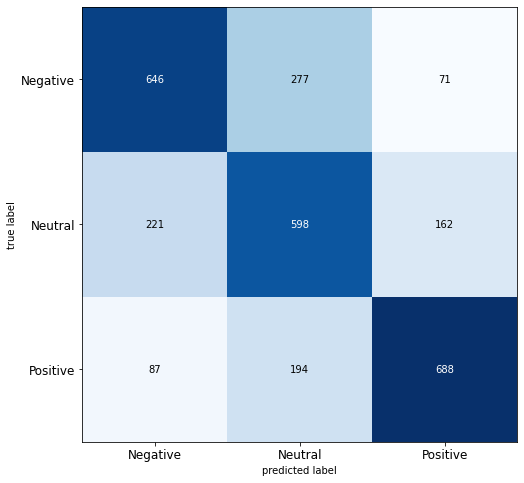

In [33]:
cm  = confusion_matrix(test_y, test_pred)
labels = ['Negative', 'Neutral', 'Positive']
from mlxtend.plotting import plot_confusion_matrix
plt.figure()
plot_confusion_matrix(cm, figsize=(8,8), hide_ticks=True, cmap=plt.cm.Blues)
plt.xticks(range(3), labels, fontsize=12)
plt.yticks(range(3), labels, fontsize=12)
plt.show()